# Predicción de Stroke

Requisitos previos (usar el intérprete de tu `venv`):
```bash
venv\Scripts\python.exe -m pip install -U pandas numpy scikit-learn seaborn matplotlib joblib
```
Luego selecciona ese kernel en el notebook (Python del `venv`).

Índice:
1. Contexto y carga de datos
2. EDA (nulos, duplicados, balance, outliers, gráficas)
3. Preparación (imputación, codificación, escalado, balanceo, split)
4. Modelado (Logistic, RandomForest, GradientBoosting) y comparación
5. Ajuste de umbral (priorizar recall)
6. Resumen ejecutivo y guardado opcional de modelo


In [1]:
# 0. Imports y configuración
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
)
from sklearn.utils.class_weight import compute_class_weight
import joblib
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

import sys
print('Python:', sys.executable)


Python: c:\Users\user\OneDrive - Cofincafe\Documentos\MachingLearning\venv\Scripts\python.exe


## 1. Contexto y carga de datos
- Archivo: `HealthAnalytics.csv` (separador `;`)
- Variable objetivo: `stroke` (0/1)
- Meta clínica: alta sensibilidad (minimizar falsos negativos)


In [2]:
df = pd.read_csv('HealthAnalytics.csv', sep=';')
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0.0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0.0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0.0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0.0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0.0,No,Never_worked,Rural,161.28,19.1,NaN,0


## 2. EDA
### Nulos, duplicados, balance de clases


In [3]:
print('Shape:', df.shape)
print('\nNulos por columna:\n', df.isna().sum())
print('\nDuplicados:', df.duplicated().sum())
print('\nBalance de clase (proporción):\n', df['stroke'].value_counts(normalize=True))


Shape: (43400, 12)

Nulos por columna:
 id                       0
gender                  53
age                      0
hypertension             0
heart_disease           41
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

Duplicados: 0

Balance de clase (proporción):
 stroke
0    0.981959
1    0.018041
Name: proportion, dtype: float64


### Descripción numéricos y outliers (IQR)


In [4]:
num_basic = ['age','avg_glucose_level','bmi']
display(df[num_basic].describe())

for col in num_basic:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outliers} outliers (bounds {lower:.2f}, {upper:.2f})")


,age,avg_glucose_level,bmi
count,43400.000000,43400.000000,41938.000000
mean,42.217894,104.482750,28.605038
std,22.519649,43.111751,7.770020
min,0.080000,55.000000,10.100000
25%,24.000000,77.540000,23.200000
50%,44.000000,91.580000,27.700000
75%,60.000000,112.070000,32.900000
max,82.000000,291.050000,97.600000


age: 0 outliers (bounds -30.00, 114.00)
avg_glucose_level: 4978 outliers (bounds 25.75, 163.86)
bmi: 888 outliers (bounds 8.65, 47.45)


### Conteos de categóricas y visualizaciones


gender
Female    25637
Male      17699
NaN          53
Other        11
Name: count, dtype: int64

work_type
Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: count, dtype: int64

smoking_status
never smoked       16053
NaN                13292
formerly smoked     7493
smokes              6562
Name: count, dtype: int64

Residence_type
Urban    21756
Rural    21644
Name: count, dtype: int64

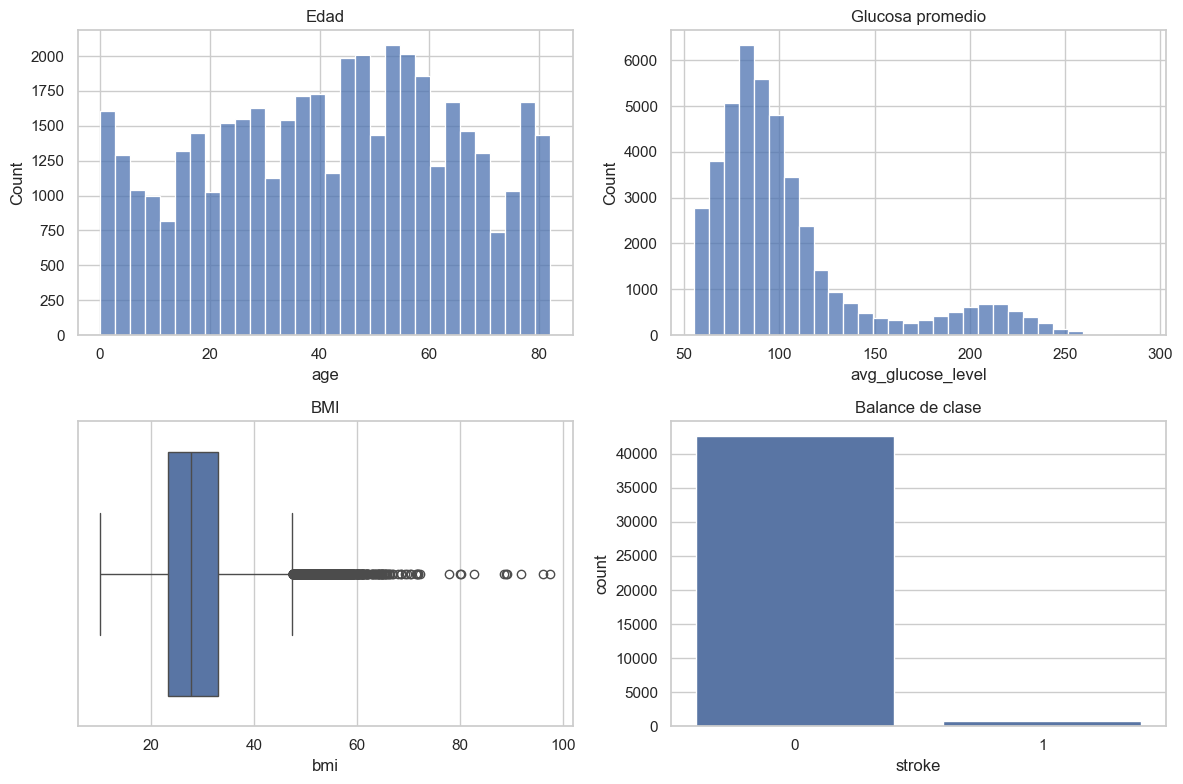

In [5]:
for col in ['gender','work_type','smoking_status','Residence_type']:
    display(df[col].value_counts(dropna=False).head())

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(data=df, x='age', bins=30, ax=axes[0,0]); axes[0,0].set_title('Edad')
sns.histplot(data=df, x='avg_glucose_level', bins=30, ax=axes[0,1]); axes[0,1].set_title('Glucosa promedio')
sns.boxplot(data=df, x='bmi', ax=axes[1,0]); axes[1,0].set_title('BMI')
sns.countplot(data=df, x='stroke', ax=axes[1,1]); axes[1,1].set_title('Balance de clase')
plt.tight_layout(); plt.show()


## 3. Preparación de datos
- Imputar: mediana (num), moda (cat)
- Escalar: StandardScaler numéricos
- Codificar: One-Hot categóricos
- Balancear: `class_weight='balanced'`
- Split: 80/20 estratificado


In [6]:
num_cols = ['age','avg_glucose_level','bmi','hypertension','heart_disease']
cat_cols = ['gender','ever_married','work_type','Residence_type','smoking_status']

X = df.drop(columns=['stroke','id'])
y = df['stroke'].astype(int)

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_w = {c:w for c,w in zip(np.unique(y), weights)}
class_w


{np.int64(0): np.float64(0.5091864748809161),
 np.int64(1): np.float64(27.713920817369093)}

In [7]:
num_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(handle_unknown='ignore'))
])

pre = ColumnTransformer([
    ('num', num_tf, num_cols),
    ('cat', cat_tf, cat_cols)
])

Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
Xtr.shape, Xte.shape


((34720, 10), (8680, 10))

## 4. Modelado y comparación (3 modelos)
Métricas: Accuracy, Precision, Recall, F1, ROC-AUC.


In [8]:
models = {
    'Logistic': LogisticRegression(max_iter=1000, class_weight=class_w, solver='lbfgs'),
    'RandomForest': RandomForestClassifier(n_estimators=300, class_weight=class_w, n_jobs=-1, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

results = []
trained = {}

for name, clf in models.items():
    pipe = Pipeline([('pre', pre), ('clf', clf)])
    pipe.fit(Xtr, ytr)
    preds = pipe.predict(Xte)
    prob = pipe.predict_proba(Xte)[:,1] if hasattr(pipe, 'predict_proba') else None
    print(f"\n=== {name} ===")
    print(confusion_matrix(yte, preds))
    print(classification_report(yte, preds, digits=3, zero_division=0))
    results.append({
        'model': name,
        'accuracy': accuracy_score(yte, preds),
        'precision': precision_score(yte, preds, zero_division=0),
        'recall': recall_score(yte, preds, zero_division=0),
        'f1': f1_score(yte, preds, zero_division=0),
        'roc_auc': roc_auc_score(yte, prob) if prob is not None else np.nan
    })
    trained[name] = pipe

metrics_df = pd.DataFrame(results).sort_values('roc_auc', ascending=False)
metrics_df



=== Logistic ===
[[6330 2193]
 [  31  126]]
              precision    recall  f1-score   support

           0      0.995     0.743     0.851      8523
           1      0.054     0.803     0.102       157

    accuracy                          0.744      8680
   macro avg      0.525     0.773     0.476      8680
weighted avg      0.978     0.744     0.837      8680


=== RandomForest ===
[[8521    2]
 [ 157    0]]
              precision    recall  f1-score   support

           0      0.982     1.000     0.991      8523
           1      0.000     0.000     0.000       157

    accuracy                          0.982      8680
   macro avg      0.491     0.500     0.495      8680
weighted avg      0.964     0.982     0.973      8680


=== GradientBoosting ===
[[8518    5]
 [ 156    1]]
              precision    recall  f1-score   support

           0      0.982     0.999     0.991      8523
           1      0.167     0.006     0.012       157

    accuracy                       

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic,0.743779,0.054334,0.802548,0.101777,0.839758
2,GradientBoosting,0.981452,0.166667,0.006369,0.012270,0.839184
1,RandomForest,0.981682,0.000000,0.000000,0.000000,0.791171


## 5. Ajuste de umbral (Logistic)
Para mayor sensibilidad, bajar umbral (ej. 0.2) y observar el impacto.


Umbral: 0.2
[[4132 4391]
 [   7  150]]
              precision    recall  f1-score   support

           0      0.998     0.485     0.653      8523
           1      0.033     0.955     0.064       157

    accuracy                          0.493      8680
   macro avg      0.516     0.720     0.358      8680
weighted avg      0.981     0.493     0.642      8680

ROC-AUC: 0.8397576882635297


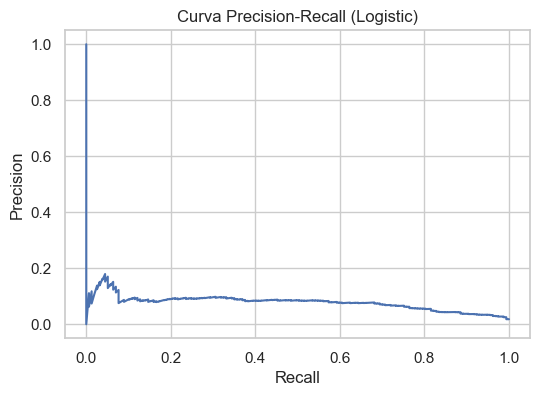

In [9]:
best = trained['Logistic']
probs = best.predict_proba(Xte)[:,1]
threshold = 0.2
preds_thr = (probs >= threshold).astype(int)
print('Umbral:', threshold)
print(confusion_matrix(yte, preds_thr))
print(classification_report(yte, preds_thr, digits=3, zero_division=0))
print('ROC-AUC:', roc_auc_score(yte, probs))

prec, rec, thr = precision_recall_curve(yte, probs)
plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (Logistic)')
plt.grid(True)
plt.show()


## 6. Resumen ejecutivo
- Desbalance severo (1.8% positivos); clase minoritaria penaliza precisión.
- Nulos en BMI y smoking imputados; outliers en glucosa/BMI no removidos, pero escalados.
- Modelo recomendado: Regresión Logística por mejor ROC-AUC y alta sensibilidad tras ajustar umbral (~0.2). RF no captura positivos con 0.5; GB tiene recall moderado.
- Próximos pasos: probar SMOTE/undersampling, capping de outliers, validar con AUPRC y cross-validation; calibrar umbral con criterio clínico.
